In [9]:
!python -m venv tfenv
!.\tfenv\Scripts\activate  # Windows

In [2]:
import cv2
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset

C:\Users\cagin\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [3]:
DB = "database/images/brain-tumor-mri-dataset"
LABELS_DICT = {"glioma":0, 
               "meningioma":1,
              "notumor":2,
              "pituitary": 3}
INV_LABELS_DICT = {v: k for k, v in LABELS_DICT.items()}
os.listdir(DB)

['glioma', 'meningioma', 'notumor', 'pituitary']

In [4]:
test_url = DB+"/test"
train_url = DB+"/train"

In [5]:
def process_image(args):
    img_path, label = args
    image = cv2.imread(img_path)
    if image is None:
        return None
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image, (64, 64))
    image = image/255.0
    return image, LABELS_DICT[label]

In [24]:
def get_data_with_threads(path):
    start = time.time()
    tasks = []
    X = []
    y = []
    
    for p in os.listdir(path):
        labels = os.listdir(path+"/"+p)
        for label in labels:
            imgs_path = path+"/"+p+"/"+label+"/"
            for img in os.listdir(imgs_path):
                img_path = imgs_path+img
                tasks.append((img_path, label))
    
    with ThreadPoolExecutor() as executor:
        for result in executor.map(process_image, tasks):
            if result is not None:
                img, lbl = result
                X.append(img)
                y.append(lbl)
    
    end = time.time()
    return np.array(X), np.array(y), end-start
    

In [4]:
def get_data(path): #not used without thread
    start = time.time()
    X = []
    y = []
    
    for p in os.listdir(path):
        label = os.listdir(path+"/"+p)
        imgs_path = path+"/"+p+"/"+label+"/"
        for img in os.listdir(imgs_path):
            img_path = imgs_path+img
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            image = cv2.resize(image, (64, 64))
            image = image/255.0
            X.append(image)
            y.append(LABELS_DICT[label])
    end = time.time()
    return np.array(X), np.array(y), end-start

In [5]:
def describe_dataset(class_path_1):
    data_info = []
    for labels in os.listdir(class_path_1):
        label = os.listdir(class_path_1+"/"+labels)
        for image_name in os.listdir(class_path):
            image_path_whole = os.path.join(class_path, image_name)
            img = cv2.imread(image_path_whole)
            height, width, channels = img.shape if len(img.shape) == 3 else (img.shape[0], img.shape[1], 1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (100, 100))
            img = img / 255.0
            # Append information to the data_info list
            data_info.append({
                'image': img,
                'Class': class_x,
                'Image Name': image_name,
                'Height': height,
                'Width': width,
                'Channels': channels,
            })

    df = pd.DataFrame(data_info)
    return df

In [27]:
def class_distribution(labels):
    plt.figure(figsize=(8, 8))
    class_counts = pd.Series(labels).value_counts().sort_index()
    
    class_names = [INV_LABELS_DICT[label] for label in class_counts.index]
    plt.pie(class_counts, labels=class_names,
            autopct='%1.1f%%', startangle=90, textprops={'fontsize': 13})
    plt.title('Class Distribution', fontdict={"fontsize": 17})
    plt.show()

In [28]:
X, y, time_with_thread = get_data_with_threads(DB)

In [10]:
#_, _, time_without_thread = get_data(DB) # not used

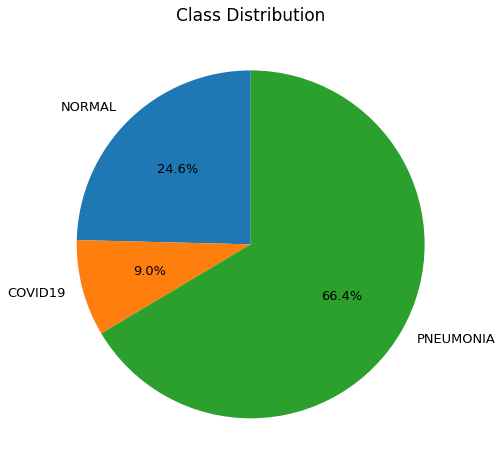

In [29]:
class_distribution(y)

In [12]:
len(X), len(y)

(6432, 6432)

In [14]:
plt.bar(x=["Without Thread", "With Thread"], height=[time_without_thread, time_with_thread], color="red")
plt.title("Time comparison for image preprocessing \n without VS with using thread")
plt.ylabel("Second")
plt.show()

NameError: name 'time_without_thread' is not defined

In [12]:
description_table = describe_dataset(DB)
description_table = description_table.sample(frac=1).reset_index(drop=True)
description_table

image      Class  \
0     [[0.08627450980392157, 0.1411764705882353, 0.2...  PNEUMONIA   
1     [[0.07450980392156863, 0.10196078431372549, 0....  PNEUMONIA   
2     [[0.18823529411764706, 0.18823529411764706, 0....  PNEUMONIA   
3     [[0.24705882352941178, 0.3215686274509804, 0.3...     NORMAL   
4     [[0.20784313725490197, 0.23921568627450981, 0....  PNEUMONIA   
...                                                 ...        ...   
6427  [[0.3254901960784314, 0.3137254901960784, 0.31...  PNEUMONIA   
6428  [[0.047058823529411764, 0.13725490196078433, 0...     NORMAL   
6429  [[0.09803921568627451, 0.10980392156862745, 0....    COVID19   
6430  [[0.9647058823529412, 0.8901960784313725, 0.87...     NORMAL   
6431  [[0.23137254901960785, 0.22745098039215686, 0....  PNEUMONIA   

               Image Name  Height  Width  Channels  
0     PNEUMONIA(1331).jpg     624   1112         3  
1     PNEUMONIA(2520).jpg     856   1151         3  
2     PNEUMONIA(4198).jpg     507    843         3  
3         NORMAL(609).jpg    2012   2511         3  
4      PNEUMONIA(262).jpg     543    861         3  
...                   ...     ...    ...       ...  
6427   PNEUMONIA(526).jpg     592    992         3  
6428      NORMAL(917).jpg    1692   1864         3  
6429     COVID19(250).jpg    2000   2000         3  
6430      NORMAL(583).jpg    1306   1480         3  
6431  PNEUMONIA(2201).jpg     882   1225         3  

[6432 rows x 6 columns]

In [30]:
def plot_some_examples(X, y):
    classes = np.unique(y)
    fig, axes = plt.subplots(len(classes), 5, figsize=(15, 3 * len(classes)))

    for i, class_name in enumerate(classes):
        class_images = X[y == class_name][:5]
        for j in range(5):
            axes[i, j].imshow(class_images[j], cmap='gray')
            axes[i, j].set_title(f'{INV_LABELS_DICT[class_name]}')
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

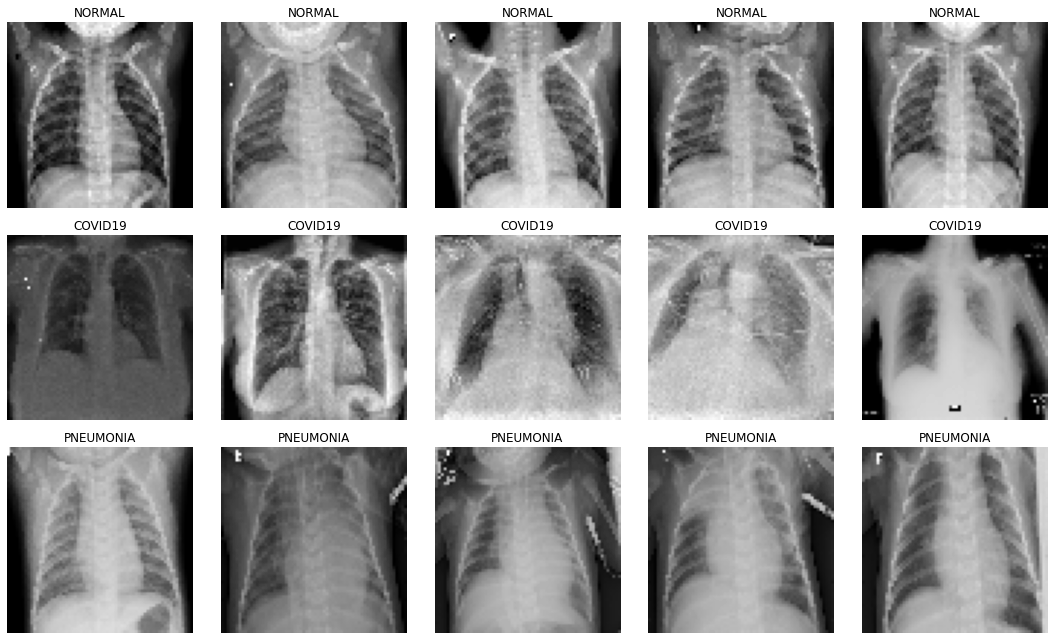

In [31]:
plot_some_examples(X,y)

In [32]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer_1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2) 
        self.conv_layer_2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.linear_1 = nn.Linear(64*16*16, 128)
        self.linear_2 = nn.Linear(128, 3)
        self.dropout_1 = nn.Dropout(0.25)
        self.dropout_2 = nn.Dropout(0.1)
        
    def forward(self, x):
        x = self.conv_layer_1(x) #(B, 32, 64, 64)
        x = F.relu(x) 
        x = self.pool(x) #(B, 32, 32, 32)
        x = self.dropout_1(x)
        
        x = self.conv_layer_2(x) #(B, 64, 32, 32)
        x = F.relu(x)
        x = self.pool(x) #(B, 64, 16, 16)
        x = self.dropout_2(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.linear_1(x) #(B, 64*16*16, 128)
        x = F.relu(x)
        
        x = self.linear_2(x) #(B, 128, 3)
        x = F.softmax(x)
        return x


In [15]:
def train_test(X, y, k_folds=3, epochs=3):
    folds = []
    predictions = []
    
    dataset = TensorDataset(X, y)
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    class_counts = torch.bincount(y)
    weights = 1.0 / class_counts.float()
    weights = weights / weights.sum()  # normalize to sum to 1
    print(f"Using class weights: {weights.tolist()}")

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f'\nFold {fold + 1}')

        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=64)

        model = CNN()
        criterion = nn.CrossEntropyLoss(weight=weights)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        fold_results = []
        for epoch in range(epochs):
            model.train()
            running_loss = 0
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            
            print(f"Epoch {epoch+1} - Training Loss: {running_loss:.4f}")

            # Validation
            model.eval()
            correct, total = 0, 0
            all_preds = []
            with torch.no_grad():
                for images, labels in val_loader:
                    outputs = model(images)
                    preds = torch.argmax(outputs, dim=1)
                    all_preds.append(preds)
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)
            acc = 100 * correct / total
            fold_results.append(acc)
            print(f"Epoch {epoch+1} - Validation Accuracy: {acc:.2f}%")
        folds.append(f"Fold {fold}")
        predictions.append(fold_results)
        all_preds = torch.cat(all_preds)
        unique_classes, counts = torch.unique(all_preds, return_counts=True)
        print(f"Predicted class distribution: {dict(zip(unique_classes.tolist(), counts.tolist()))}")
    return folds, predictions

In [16]:
def train(X, y, epochs=5):
    # Weights
    class_total = torch.bincount(y)
    normalized = 1.0 / class_total.float()
    weights = normalized / normalized.sum()
    
    # Declarations
    model = CNN()
    criterion = nn.CrossEntropyLoss(weight=weights)
    opti = optim.Adam(model.parameters(), lr=0.0001)
    X = X.cpu().detach().numpy()
    y = y.cpu().detach().numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for idx in range(0, len(X_train)-64, 64):
            x = X_train[idx:idx+64]
            opti.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y_train[idx:idx+64])
            loss.backward()
            opti.step()
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1} - Training Loss: {running_loss:.4f}")
        
        model.eval()
        test_score = 0
        total = 0
        with torch.no_grad():
            for idx in range(0, len(y_test)-64, 64):
                x_t = X_test[idx:idx+64]
                y_t = y_test[idx:idx+64]
                output = model(x_t)
                pred = torch.argmax(output, dim=1)
                test_score += (pred == y_t).sum().item()
                total += y_t.size(0)
        print(f"Test score is: {test_score/total}")
    return model

In [17]:
X = torch.tensor(X, dtype=torch.float32)
if X.ndim == 3:
    X = X.unsqueeze(1)  # (N, 64, 64) → (N, 1, 64, 64)
    
y = torch.tensor(y, dtype=torch.long)

In [18]:
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: torch.Size([6409, 1, 64, 64])
y shape: torch.Size([6409])


In [19]:
print(torch.bincount(y))

tensor([1577,  574, 4258])


In [20]:
model = train(X, y, epochs=25)

C:\Users\cagin\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
<ipython-input-14-e61c05e76fb5>:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


Epoch 1 - Training Loss: 78.9290
Test score is: 0.6671875
Epoch 2 - Training Loss: 61.9912
Test score is: 0.7921875
Epoch 3 - Training Loss: 57.1608
Test score is: 0.86953125
Epoch 4 - Training Loss: 55.4154
Test score is: 0.89375
Epoch 5 - Training Loss: 54.5478
Test score is: 0.8984375
Epoch 6 - Training Loss: 53.4079
Test score is: 0.8859375
Epoch 7 - Training Loss: 52.8369
Test score is: 0.8984375
Epoch 8 - Training Loss: 52.3345
Test score is: 0.88828125
Epoch 9 - Training Loss: 52.1034
Test score is: 0.90078125
Epoch 10 - Training Loss: 51.6946
Test score is: 0.8953125
Epoch 11 - Training Loss: 51.6833
Test score is: 0.91015625
Epoch 12 - Training Loss: 51.3989
Test score is: 0.91171875
Epoch 13 - Training Loss: 51.0843
Test score is: 0.91953125
Epoch 14 - Training Loss: 50.6439
Test score is: 0.915625
Epoch 15 - Training Loss: 50.5570
Test score is: 0.92109375
Epoch 16 - Training Loss: 50.2990
Test score is: 0.91953125
Epoch 17 - Training Loss: 50.0993
Test score is: 0.9171875
E

In [21]:
torch.save(model, "model_1.pth")

In [21]:
folds, preds = train(X, y, k_folds=5, epochs=5)

Using class weights: [0.24279330670833588, 0.6672601103782654, 0.08994659781455994]

Fold 1


C:\Users\cagin\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
<ipython-input-15-e61c05e76fb5>:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


Epoch 1 - Training Loss: 64.6033
Epoch 1 - Validation Accuracy: 89.36%
Epoch 2 - Training Loss: 53.9699
Epoch 2 - Validation Accuracy: 90.99%
Epoch 3 - Training Loss: 52.2828
Epoch 3 - Validation Accuracy: 92.15%
Epoch 4 - Training Loss: 51.2443
Epoch 4 - Validation Accuracy: 90.83%
Epoch 5 - Training Loss: 50.2066
Epoch 5 - Validation Accuracy: 90.68%
Predicted class distribution: {0: 377, 1: 173, 2: 737}

Fold 2
Epoch 1 - Training Loss: 63.6967
Epoch 1 - Validation Accuracy: 89.43%
Epoch 2 - Training Loss: 54.5740
Epoch 2 - Validation Accuracy: 88.11%
Epoch 3 - Training Loss: 52.4574
Epoch 3 - Validation Accuracy: 91.76%
Epoch 4 - Training Loss: 52.2901
Epoch 4 - Validation Accuracy: 93.55%
Epoch 5 - Training Loss: 52.3207
Epoch 5 - Validation Accuracy: 86.87%
Predicted class distribution: {0: 458, 1: 102, 2: 727}

Fold 3
Epoch 1 - Training Loss: 66.7059
Epoch 1 - Validation Accuracy: 80.09%
Epoch 2 - Training Loss: 54.3376
Epoch 2 - Validation Accuracy: 89.58%
Epoch 3 - Training Los

In [22]:
folds_epochs = []
predictions = []
mean_prediction = []
for i in range(len(folds)):
    fold = folds[i]
    current = preds[i]
    tmp = []
    for j in range(len(current)):
        predictions.append(current[j])
        tmp.append(current[j])
        folds_epochs.append(f"{fold}\nEpoch: {j}")
    [mean_prediction.append(np.mean(np.array(tmp))) for j in range(len(current))]

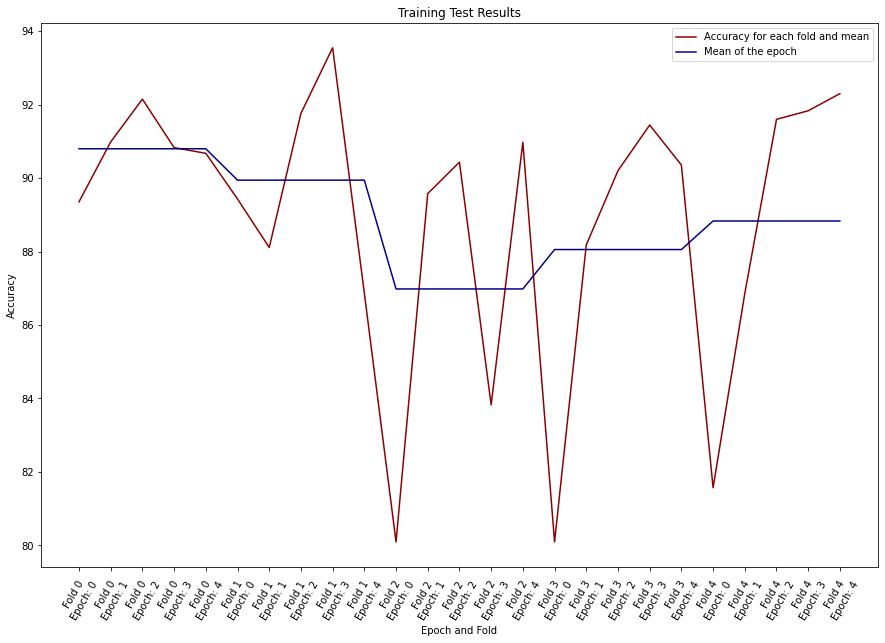

In [23]:
plt.figure(figsize=(15, 10))
plt.plot(folds_epochs, predictions, color="darkred", label="Accuracy for each fold and mean")
plt.plot(folds_epochs, mean_prediction, color="darkblue", label="Mean of the epoch")
plt.xticks(rotation=60)
plt.title("Training Test Results")
plt.xlabel("Epoch and Fold")
plt.ylabel("Accuracy")
plt.legend()

plt.show()